0.329350899248
93.9644606674
96.4843753506


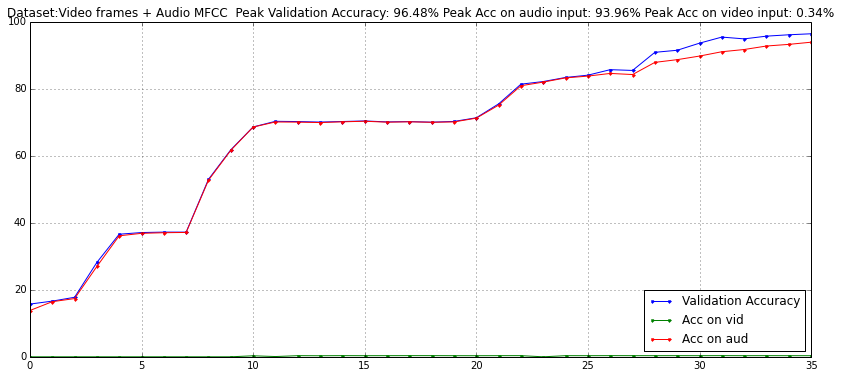

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sensors_ini.rnns.lasagne_utils import save_model, store_in_log, load_model, load_log, replace_updates_nans_with_zero
import lasagne
# One to investigate:
filename = 'lipreading_Grid_mfcc_frames1_best'

# Load history from file
history = load_log(filename)

plt.figure(figsize=(14,6))
#plt.subplot(2,1,1)
#plt.plot(history['train_acc'], '.-')
plt.plot(history['val_acc'], '.-')
val_no_aud_acc=[x for x in history['val_no_aud_acc']]
val_no_vid_acc=[x  for x in history['val_no_vid_acc']]

plt.plot(val_no_aud_acc, '.-')
plt.plot(val_no_vid_acc, '.-')
plt.legend(['Validation Accuracy','Acc on vid','Acc on aud'],loc='lower right')
#plt.legend(['Accuracy', 'Validation Accuracy'],loc='lower right')
plt.title('Dataset:Video frames + Audio MFCC  Peak Validation Accuracy: {:.2f}% Peak Acc on audio input: {:.2f}% Peak Acc on video input: {:.2f}% '
          .format(np.max(history['val_acc']),np.max(val_no_vid_acc),np.max(val_no_aud_acc)))
plt.grid(which='both')
'''
plt.subplot(2,1,2)
plt.semilogy(history['train_err'], '.-')
plt.semilogy(history['val_err'], '.-')
plt.semilogy(history['val_no_aud_err'], '.-')
plt.semilogy(history['val_no_vid_err'], '.-')
plt.legend(['Loss', 'Validation Loss'])
plt.grid(which='both')
plt.savefig('grid_accuracy_history.png')'''
print(val_no_aud_acc[-1])
print(val_no_vid_acc[-1])
print(history['val_acc'][-1])

In [2]:
import numpy as np
import theano.tensor as T
import theano
import glob
from lipreading_utils import pad_sequences,find_data_mean, find_data_std, HDF5LipReadingIterator, HDF5LipReadingIterator_events,HDF5LipReadingIterator_sep,ftensor5, get_train_and_val_fn, vocab_size, print_model
from lipreading_models import get_dan_original_rnn,get_network,get_network_12classes,get_dan_original_video,get_video_coch_net
import h5py

#h5file = '/media/yy/Seagate Expansion Drive1/hwGrid_20 (copy).hdf5'

h5file_audio = '/media/yy/My Passport/lipread_data/current_used_datasets/Grid_audio.hdf5'
#h5file_coch='/media/yy/Seagate Expansion Drive1/grid_coch_recap/grid_coch_ctime_40_on.hdf5'
#h5file_coch='/media/yy/Seagate Expansion Drive1/grid_coch_recap/grid_coch_ctime_40_on.hdf5'
h5file_video='/media/yy/My Passport/lipread_data/current_used_datasets/Grid_video.hdf5'
#h5file='/home/yy/thesis/workspace/cochlp_6_17.hdf5'
# Get the same random data split
np.random.seed(42)   
# Get dataset
log = load_log(filename)

# Load dataset
dataset_video=h5py.File(h5file_video, "r")
dataset_audio = h5py.File(h5file_audio, "r")
print('Train set size: {} sentences.'.format(len(dataset_video['train_labels'])))
print('Test set size: {} sentences.'.format(len(dataset_video['test_labels'])))


# Load network

aud_in   = T.ftensor3('aud_in')
vid_in   = ftensor5('vid_in')
aud_mask = T.bmatrix('aud_mask')
#vid_in   = ftensor5('vid_in')
vid_mask = T.bmatrix('vid_mask')
targets  = T.fmatrix('targets')
network = get_dan_original_rnn(aud_in, vid_in)
load_model(filename, network)

# Get data iterator
d = HDF5LipReadingIterator_sep()
# Compile the output fn
print('Compiling output functions...')
train_fn, val_fn, out_fn = get_train_and_val_fn([aud_in, vid_in], targets, network)

#accuracy=get_network_output(vid_in, targets, network)

#acc_fn = theano.function([vid_in], accuracy)
print('Compiled.')

# Load a data
'''
for data in d.flow(dataset_video,dataset_audio, 'test', batch_size=128, shuffle=False, blankout=0,audio_blankout_prob=0):
    
    aud_in, aud_mask, vid_in, vid_mask, bY =data
    output = out_fn(aud_in,vid_in)
    err, acc,debug_var2 = val_fn(aud_in,vid_in,  bY)
    no_aud_err, no_aud_acc,_= val_fn(aud_in*0., vid_in, bY)
    no_vid_err, no_vid_acc,_ = val_fn(aud_in, vid_in*0., bY)
    #err, acc,debug_var2 = val_fn(vid_in, bY)
    #ind, err2,acc2,test_pred_arr,test_prediction=val_fn2(vid_in,bY)
    #ind, ind_x, ind_y, test_pred_arr = val_fn2(vid_in)
    break
print('Data prepped and passed through.')'''
#print(acc)
#print(debug_var2)

Train set size: 19205 sentences.
Test set size: 2160 sentences.
Compiling output functions...
Compiled.


"\nfor data in d.flow(dataset_video,dataset_audio, 'test', batch_size=128, shuffle=False, blankout=0,audio_blankout_prob=0):\n    \n    aud_in, aud_mask, vid_in, vid_mask, bY =data\n    output = out_fn(aud_in,vid_in)\n    err, acc,debug_var2 = val_fn(aud_in,vid_in,  bY)\n    no_aud_err, no_aud_acc,_= val_fn(aud_in*0., vid_in, bY)\n    no_vid_err, no_vid_acc,_ = val_fn(aud_in, vid_in*0., bY)\n    #err, acc,debug_var2 = val_fn(vid_in, bY)\n    #ind, err2,acc2,test_pred_arr,test_prediction=val_fn2(vid_in,bY)\n    #ind, ind_x, ind_y, test_pred_arr = val_fn2(vid_in)\n    break\nprint('Data prepped and passed through.')"

In [5]:
# Load a data

for data in d.flow(dataset_video,dataset_audio, 'train', batch_size=20, shuffle=True, blankout=0,audio_blankout_prob=0):

    aud_in, aud_mask, vid_in, vid_mask, bY =data
    output = out_fn(aud_in,vid_in)
    err, acc,debug_var2 = val_fn(aud_in,vid_in,  bY)
    no_aud_err, no_aud_acc,_= val_fn(aud_in*0., vid_in, bY)
    no_vid_err, no_vid_acc,_ = val_fn(aud_in, vid_in*0., bY)
    #err, acc,debug_var2 = val_fn(vid_in, bY)
    #ind, err2,acc2,test_pred_arr,test_prediction=val_fn2(vid_in,bY)
    #ind, ind_x, ind_y, test_pred_arr = val_fn2(vid_in)
    break
print('Data prepped and passed through.')

Data prepped and passed through.


In [17]:
print(acc)
print(no_aud_acc)
print(no_vid_acc)
print(len(bY))
output_vid = out_fn(aud_in*0.,vid_in)
output_aud = out_fn(aud_in,vid_in*0.)

0.158333301544
0.383333325386
0.216666698456
20


In [ ]:
aud_in, aud_mask, vid_in, vid_mask, bY =data

np.savez('/media/yy/Seagate Expansion Drive1/single_epoch.npy', aud_in, aud_mask, vid_in, vid_mask, bY)


In [ ]:
aud_in.shape

In [ ]:
print((sum(vid_in[1])))
print((vid_in.shape))

In [ ]:

np.sum(vid_in[1][-30])


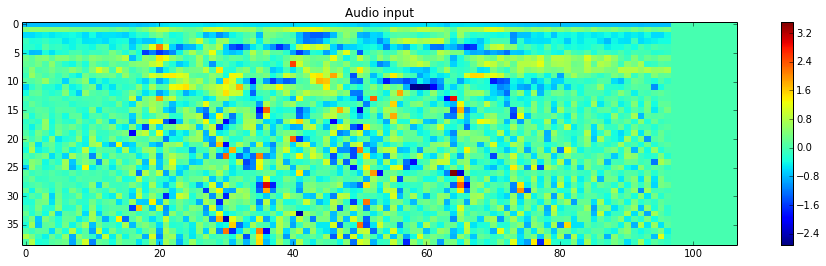

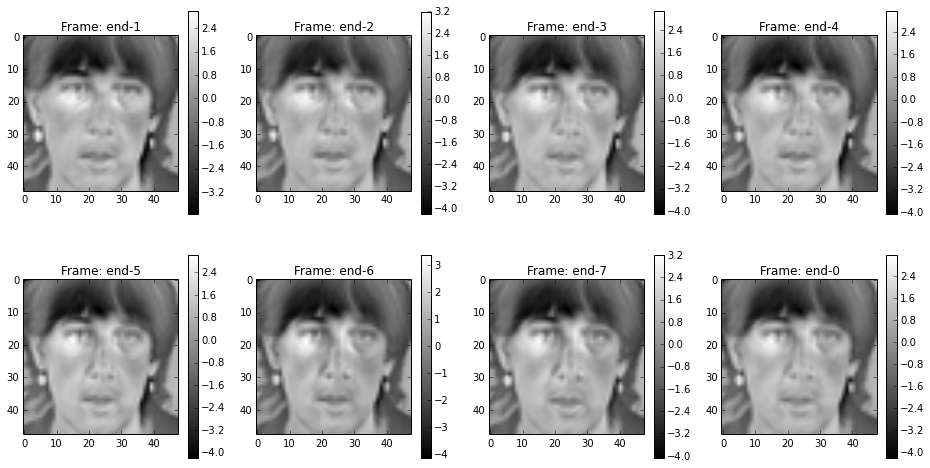

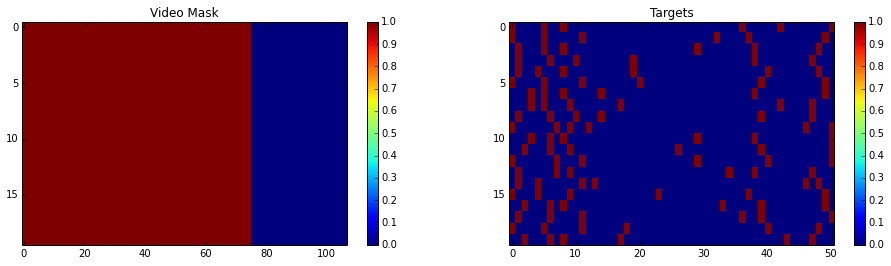

In [8]:
idx = 3


plt.figure(figsize=(16,4))
#plt.subplot(1,2,1)
plt.imshow(aud_in[idx].T, interpolation='nearest', aspect='auto')
plt.colorbar()
p
plt.title('Audio input')

'''plt.subplot(1,2,2)
plt.imshow(aud_mask, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Audio Mask')'''

plt.figure(figsize=(16,8))
# Get padded max length
max_len = vid_in.shape[1]
for i in range(8):
    plt.subplot(2,4,i)
    plt.imshow(np.squeeze(vid_in[idx][i]), cmap='gray')
    plt.title('Frame: end-{}'.format(i))
    plt.colorbar()

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.imshow(vid_mask, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Video Mask')

plt.subplot(1,2,2)
plt.imshow(bY, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Targets')

In [ ]:
idx = 1


plt.figure(figsize=(16,4))
'''plt.subplot(1,2,1)
plt.imshow(aud_in[idx].T, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Audio input')

plt.subplot(1,2,2)
plt.imshow(aud_mask, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Audio Mask')
'''
plt.figure(figsize=(16,8))
# Get padded max length
max_len = aud_in.shape[1]
for i in [-30,-29,-28]:
    plt.subplot(2,4,1)
    plt.imshow(np.squeeze(aud_in[idx][i]), cmap='gray')
    plt.title('Frame: end-{}'.format(i))
    plt.colorbar()

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.imshow(aud_mask, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Video Mask')

plt.subplot(1,2,2)
plt.imshow(bY, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Targets')

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.imshow(aud_mask, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('aud Mask')

In [ ]:
print_model_with_data(network, output)

In [ ]:
plt.figure(figsize=(4,4))
tmp=np.asarray(output[0])
tmp=tmp[0,1,0,:,:]
print(tmp.shape)
plt.imshow(np.squeeze(tmp))

plt.figure(figsize=(16,8))
for i in range(3,10):
    plt.subplot(3,3,i-3+1)
    plt.imshow(output[i][117][0], interpolation='nearest', cmap='gray')
    plt.colorbar()
    plt.title('Layer {}'.format(i))
#plt.savefig('face_through_layers.png')

In [ ]:
idx = 0
print(output[14].shape)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(output[14][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Pre-merge Video Features')
plt.subplot(1,2,2)
plt.imshow(output[16][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Pre-merge Audio Features')
#plt.savefig('merged_features.png')

In [ ]:
idx = 0
print(output[19].shape)
plt.figure(figsize=(16,8))
plt.imshow(output[19][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Post-merge Features')
#plt.savefig('merged_features.png')

In [ ]:
idx = 0
print(output_vid[19].shape)
plt.figure(figsize=(16,8))
plt.imshow(output_vid[19][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Post-merge Features, video only')
#plt.savefig('merged_features.png')

In [ ]:
idx = 0
print(output_aud[19].shape)
plt.figure(figsize=(16,8))
plt.imshow(output_aud[19][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Post-merge Features, audio only')
#plt.savefig('merged_features.png')

In [ ]:
from lipreading_utils import bow_to_said_list
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.imshow(output_aud[-1], interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Guesses')
plt.ylabel('Example Idx')
plt.subplot(2,1,2)
plt.imshow(bY, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('True Answer')
plt.ylabel('Example Idx')
plt.xlabel('Word')
plt.title('video only')
for idx in range(10):
    # Extract bag-of-words of interest
    bow = output_aud[-1][idx]
    # Find the chosen words
    print('Network guess: {}'.format(' '.join(bow_to_said_list(np.where(bow>0.5, 1, 0)))))
    #print('Network guess: {}'.format(' '.join(bow_to_said_list(test_pred_arr[idx]))))
    
    print('True: {}'.format(' '.join(bow_to_said_list(bY[idx]))))
    #print(bY[idx])
    #plt.savefig('network_guesses.png')

In [ ]:
def get_pred_category(net_output):
    num_cate=6
    #number of words in each category
    '''
    commands = ['bin', 'lay', 'place', 'set']
    colors = ['blue', 'green', 'red', 'white']
    prepositions = ['at','by','in','with']
    letters = list(set(map(chr, range(ord('a'), ord('z')+1))) - set('w'))
    digits = [str(i) for i in range(1,10)] + ['zero']
    adverbs = ['again','now','please','soon']'''
    starting_ind=[0,4,8,12,37,47]
    num_words=[4,4,4,25,10,4]
    pred=np.zeros_like(net_output)
    for sample_cnt in range(net_output.shape[0]):
        for i in range(num_cate):
            pred_ind=np.argmax(net_output[sample_cnt][starting_ind[i]:starting_ind[i]+num_words[i]])
            #print(pred_ind)
            pred[sample_cnt][pred_ind+starting_ind[i]]=1
            
    return pred

In [ ]:
pred_cate=get_pred_category(test_prediction)

from lipreading_utils import bow_to_said_list
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.imshow(output[-1], interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Guesses')
plt.ylabel('Example Idx')
plt.subplot(2,1,2)
plt.imshow(bY, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('True Answer')
plt.ylabel('Example Idx')
plt.xlabel('Word')

for idx in range(7):
    # Extract bag-of-words of interest
    bow = output[-1][idx]
    # Find the chosen words
    print('Network guess: {}'.format(' '.join(bow_to_said_list(pred_cate[idx]))))
    print('True: {}'.format(' '.join(bow_to_said_list(bY[idx]))))
    #print(bY[idx])
    #plt.savefig('network_guesses.png')

In [ ]:
bow = output[-1][0]
target_var=bY[0]
print(bow)
test_prediction_thresholded = np.where(output[-1]>0.5, 1.0, 0.0)
print(test_prediction_thresholded)
sum_of_targets = np.sum(bY,axis=1)
test_mean_mismatch_per_example = np.sum(abs(test_prediction_thresholded-bY), axis=1)/sum_of_targets
test_acc = 1.-np.mean(test_mean_mismatch_per_example)
print(test_acc)

In [ ]:
len(output[-1])

In [ ]:
#confusion matrix
#testing
from lipreading_utils import bow_to_said_list

plt.figure(figsize=(16,16))
con_mat_train=np.zeros([51, 51])
for idx in range(200):
    # Extract bag-of-words of interest
    bow = output[-1][idx]
    # Find the chosen words
    #print('Network guess: {}'.format(' '.join(bow_to_said_list(np.where(bow>0.5, 1, 0)))))
    #print('True: {}'.format(' '.join(bow_to_said_list(bY[idx]))))
    #plt.savefig('network_guesses.png')
    pred=np.where(bow>0.5, 1, 0)
    label=bY[idx]
    #print(pred)
    #print(label)
    pred_ind=np.where(pred==1)
    label_ind=np.where(label==1)
    #print(pred_ind[0])
    #print(len(pred_ind[0])-1)
    #print(len(label_ind[0])-1)
    for i in range(len(pred_ind[0])-1):
        
        con_mat_train[pred_ind[0][i]][label_ind[0][i]]=con_mat_train[pred_ind[0][i]][label_ind[0][i]]+1

plt.imshow(con_mat_train, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Testing')    

In [ ]:
#confusion matrix
#testing
from lipreading_utils import bow_to_said_list

plt.figure(figsize=(16,16))
con_mat_train=np.zeros([51, 51])
for idx in range(200):
    # Extract bag-of-words of interest
    bow = output_vid[-1][idx]
    # Find the chosen words
    #print('Network guess: {}'.format(' '.join(bow_to_said_list(np.where(bow>0.5, 1, 0)))))
    #print('True: {}'.format(' '.join(bow_to_said_list(bY[idx]))))
    #plt.savefig('network_guesses.png')
    pred=np.where(bow>0.5, 1, 0)
    label=bY[idx]
    #print(pred)
    #print(label)
    pred_ind=np.where(pred==1)
    label_ind=np.where(label==1)
    #print(pred_ind[0])
    #print(len(pred_ind[0])-1)
    #print(len(label_ind[0])-1)
    for i in range(len(pred_ind[0])-1):
        
        con_mat_train[pred_ind[0][i]][label_ind[0][i]]=con_mat_train[pred_ind[0][i]][label_ind[0][i]]+1

plt.imshow(con_mat_train, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Testing,video only')    